# EDA

## Import Libraries

In [115]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from sklearn import metrics
from matplotlib import pyplot
import itertools
import seaborn as sns

## Viewing Images

In this project, we are working with images of chest X-rays which we are classifying into two categories: pneumonia or normal. First, let's look at the difference between these.

#### Normal:
<table style="border-collapse: collapse;">
    <tr>
        <td style="border: none;"><img src="Images/normal1.jpeg" alt="normal1" width="450px"/></td>
        <td style="border: none;"><img src="Images/normal2.jpeg" alt="normal2" width="400px"/></td>
        <td style="border: none;"><img src="Images/normal3.jpeg" alt="normal3" width="400px"/></td>
    </tr>
</table>

#### Pneumonia:
<table style="border-collapse: collapse;">
    <tr>
        <td style="border: none;"><img src="Images/pneumonia1.jpeg" alt="pneumonia1" width="450px"/></td>
        <td style="border: none;"><img src="Images/pneumonia2.jpeg" alt="pneumonia2" width="400px"/></td>
        <td style="border: none;"><img src="Images/pneumonia3.jpeg" alt="pneumonia3" width="400px"/></td>
    </tr>
</table>

From <a href="https://www.radiologyinfo.org/en/info.cfm?pg=pneumonia">Radiology.org</a>: <br> _Pneumonia is an infection that causes inflammation in one or both of the lungs. It can be caused by a virus, bacteria, fungi or other germs. The infection is usually acquired when a person breathes in air carrying germs._

When radiologists look at these images, they look for white spots called infiltrates that identify an infection, as well as abscesses or fluids that could be caused by pneumonia. We find it a bit difficult to tell the difference between these due to not being trained radiologists, but we can definitely say some x-rays (such as the leftmost pneumonia picture above) look more "cloudy" than others.

Further reviewing our data, we can see that:
* Every image is grayscale, only containing color data in the gray channel (as opposed to RGB alpha channels).
* Each image has a different pixel dimension, many with non-square aspect ratios. 
* Most images have tick marks on the left and right edges.
* Many images contain other text near the edges.
* Some images show the patient rotated at an angle.

<img src="Images/tp_512_prob.png" alt="image_problems" width="450px"/>

To remedy any issues caused by this, we will change parameters of ImageDataGenerator while creating our models.

## Class Distribution

Before we start modeling, we want to check for class imbalance. Our data is split into 3 directories, each holding the images needed for our test, train, and validation sets. We'll add up the number of files in these directories to get the count of data points in each class.

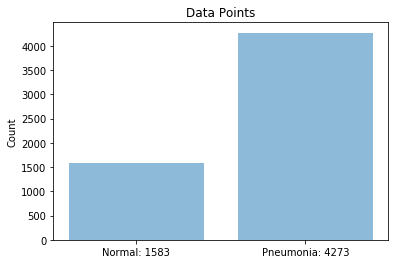

In [2]:
n_count = len(os.listdir('chest_xray/test/NORMAL')) + len(os.listdir('chest_xray/train/NORMAL')) + len(os.listdir('chest_xray/val/NORMAL'))
p_count = len(os.listdir('chest_xray/test/PNEUMONIA')) + len(os.listdir('chest_xray/train/PNEUMONIA')) + len(os.listdir('chest_xray/val/PNEUMONIA'))

objects = (f'Normal: {n_count}', f'Pneumonia: {p_count}')
y_pos = np.arange(len(objects))

plt.bar(y_pos, [n_count,p_count], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Data Points')

plt.show()

We can see we have a 27:73 split. This isn't a huge imbalance, but definitely something to keep in mind when evaluating our models, as our null accuracy is 73%. This is the accuracy we could achieve by always predicting the most frequent class.

# Modeling

## Gather Image Data

First, we get the image data from our folders.

In [3]:
base_gen = ImageDataGenerator(rescale=1./255)

train_generator = base_gen.flow_from_directory('chest_xray/train/', target_size=(64, 64), batch_size = 5218)
test_generator = base_gen.flow_from_directory('chest_xray/test/', target_size=(64, 64), batch_size = 624)
val_generator = base_gen.flow_from_directory('chest_xray/val/', target_size=(64, 64), batch_size = 18)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Next, we'll make a list of matrices per image from this data.

In [11]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [19]:
class_labels = list(train_generator.class_indices.keys())

In [20]:
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

train_images shape: (5216, 64, 64, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 64, 64, 3)
test_labels shape: (624, 2)
val_images shape: (16, 64, 64, 3)
val_labels shape: (16, 2)


In [180]:
train_labels

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [179]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Our label arrays have 2 columns, one for True and one for False. We only need one of these as having two is redundant.

We see that the second index is for pneumonia. This means if there is a 0 in this column the picture is clasified as normal, and 1 if it's classified as pneumonia. Let's keep this second column as our labels.

In [181]:
train_y = np.reshape(train_labels[:,1], (5216,1))
test_y = np.reshape(test_labels[:,1], (624,1))
val_y = np.reshape(val_labels[:,1], (16,1))

In [182]:
train_y

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

## Baseline Model

In [22]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [23]:
%%time
history_1 = model_1.fit(train_images,
                    train_y,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images, val_y))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 13s 2ms/step - loss: 0.5761 - acc: 0.7337 - val_loss: 0.7584 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 13s 3ms/step - loss: 0.5241 - acc: 0.7448 - val_loss: 1.0450 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 14s 3ms/step - loss: 0.4612 - acc: 0.7876 - val_loss: 0.9883 - val_acc: 0.5625
Epoch 4/30
5216/5216 [==============================] - 13s 3ms/step - loss: 0.3803 - acc: 0.8378 - val_loss: 0.7974 - val_acc: 0.6250
Epoch 5/30
5216/5216 [==============================] - 14s 3ms/step - loss: 0.3014 - acc: 0.8763 - val_loss: 0.5713 - val_acc: 0.6875
Epoch 6/30
5216/5216 [==============================] - 12s 2ms/step - loss: 0.2511 - acc: 0.8986 - val_loss: 0.9012 - val_acc: 0.6250
Epoch 7/30
5216/5216 [==============================] - 14s 3ms/step - loss: 0.2145 - acc: 0.9132 - val_loss: 0.4228 - val_acc: 0.8750
Epoch 8/3

## Evaluating Model

In [183]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if i == 0:
            plt.text(j-0.1, i+0.3, format(cm[i, j], fmt), color="white" if cm[i, j] > thresh else "black")
        if i == 1:
            plt.text(j-0.1, i-0.2, format(cm[i, j], fmt), color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label', weight='bold')
    plt.xlabel('Predicted Label', weight='bold')
    plt.show()

In [189]:
def evaluate_test(model, history, class_labels, train_X, test_X, test_y, train_y):
    """Return evaluation metrics for given model on given train and test sets."""
    train_loss, train_acc = model_1.evaluate(train_X, train_y, verbose=0)
    test_loss, test_acc = model_1.evaluate(test_X, test_y, verbose=0)
    print('Accuracy \n Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    print('Loss \n Train: %.3f, Test: %.3f \n' % (train_loss, test_loss))
    # plot loss during training
    pyplot.subplots_adjust(hspace = .5, wspace = 0.5)
    pyplot.subplot(211)
    pyplot.title('Loss', weight='bold')
    pyplot.plot(history_1.history['loss'], label='train')
    pyplot.plot(history_1.history['val_loss'], label='test')
    pyplot.legend()
    # plot accuracy during training
    pyplot.subplot(212)
    pyplot.title('Accuracy', weight='bold')
    pyplot.plot(history_1.history['acc'], label='train')
    pyplot.plot(history_1.history['val_acc'], label='test')
    pyplot.legend()
    pyplot.show()
    print('\n')
    # predict probabilities for test set
    yhat_probs = model_1.predict(test_X, verbose=0)
    # predict crisp classes for test set
    yhat_classes = model_1.predict_classes(test_X, verbose=0)
    # reduce to 1d array
    yhat_probs = yhat_probs[:, 0]
    yhat_classes = yhat_classes[:, 0]
    # calculate metrics
    report = metrics.classification_report(test_y, yhat_classes, target_names=class_labels)
    confusion_matrix = metrics.confusion_matrix(test_y, yhat_classes)
    plot_confusion_matrix(confusion_matrix, class_labels, cmap=plt.cm.Blues)
    print('\n')
    return report

Accuracy 
 Train: 0.966, Test: 0.780
Loss 
 Train: 0.090, Test: 0.672 



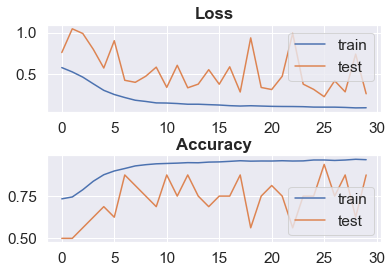



Confusion Matrix, without normalization


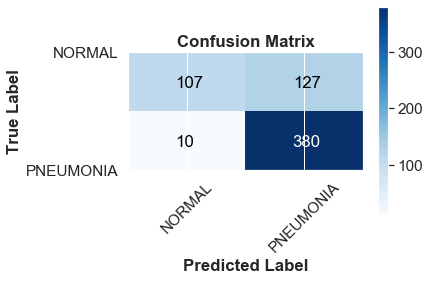



              precision    recall  f1-score   support

      NORMAL       0.91      0.46      0.61       234
   PNEUMONIA       0.75      0.97      0.85       390

    accuracy                           0.78       624
   macro avg       0.83      0.72      0.73       624
weighted avg       0.81      0.78      0.76       624



In [190]:
print(evaluate_test(model_1, history_1, class_labels, train_images, test_images, test_y, train_y))